<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/BoneAgePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

In [2]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def dataset_path(*rel_path):
    return os.path.join('/content/drive/My Drive/Project_Boneage', *rel_path);

In [4]:
dataset_path

<function __main__.dataset_path(*rel_path)>

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
class BoneAgeTrainingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double(),\
               torch.from_numpy(male).double()

In [7]:
class BoneAgeValidatingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage zscore'][idx])).double(),\
               torch.from_numpy(male).double()

In [8]:
class BoneAgeTestingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['sex'][idx] == 'M') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['Case ID'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [9]:
class BoneAgePredictor(nn.Module):
    def __init__(self):
        super(BoneAgePredictor, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 10, 5)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(10)
        # Layer 2
        self.conv2 = nn.Conv2d(10, 20, 5)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.batch2 = nn.BatchNorm2d(20)
        # Layer 3
        self.conv3 = nn.Conv2d(20, 40, 5)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.batch3 = nn.BatchNorm2d(40)
        # Layer 4
        self.conv4 = nn.Conv2d(40, 40, 5)
        nn.init.kaiming_normal_(self.conv4.weight)
        self.batch4 = nn.BatchNorm2d(40)
        # Layer 5
        #self.conv5 = nn.Conv2d(16, 16, 3)
        #nn.init.kaiming_normal_(self.conv5.weight)
        #self.batch5 = nn.BatchNorm2d(16)
        # Fully connected
        self.fc1 = nn.Linear(1001, 64)
        self.fc2 = nn.Linear(65, 10)
        self.fc3 = nn.Linear(11, 1)

    def forward(self, x, m):
        # Layer 1
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        # Layer 2
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        # Layer 3
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.max_pool2d(x, 3)
        # Layer 4
        x = F.relu(self.batch4(self.conv4(x)))
        x = F.max_pool2d(x, 3)
        # Layer 4
        #x = F.relu(self.batch5(self.conv5(x)))
        #x = F.max_pool2d(x, 2)
        # Pooling
        x = x.view(-1,1000)
        x = torch.cat((x,m), axis = 1)
        x = self.fc1(x)
        x = torch.cat((x,m), axis = 1)
        x = self.fc2(x)
        x = torch.cat((x,m), axis = 1)
        x = self.fc3(x)
        return x

In [10]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target, male) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, male)
        loss = F.l1_loss(output.view(-1), target)
        loss.backward()   
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [11]:
def val(model, device, loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss           
    loss /= len(loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [12]:
def test(model, device, loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
training_data_loader = torch.utils.data.DataLoader(
    BoneAgeTrainingDataset('train_z.csv', 'boneage_training_dataset'),
    batch_size=64, shuffle=True, **kwargs)
validating_data_loader = torch.utils.data.DataLoader(
    BoneAgeValidatingDataset('validation_z.csv', 'boneage_validation_dataset'),
    batch_size=64, shuffle=True, **kwargs)
testing_data_loader = torch.utils.data.DataLoader(
    BoneAgeTestingDataset('boneage-test-dataset.csv', 'boneage-test-dataset'),
    batch_size=64, shuffle=True, **kwargs)

In [14]:
device

device(type='cpu')

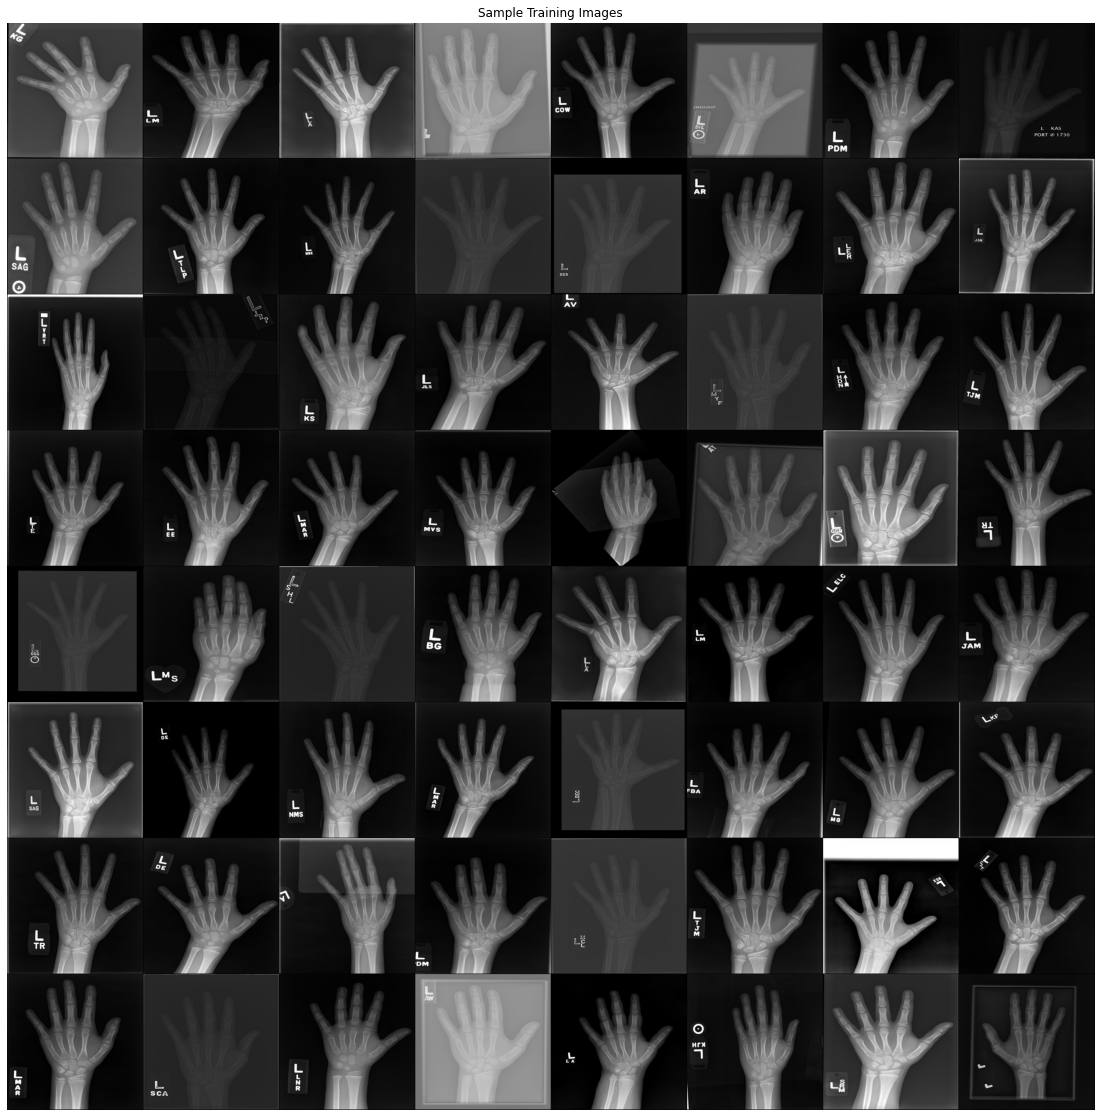

In [15]:
sample_batch = next(iter(training_data_loader))
plt.figure(figsize=(20, 20)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

In [16]:
model = BoneAgePredictor().double().to(device)
print(model)
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=1e-3, verbose=True)

BoneAgePredictor(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
  (batch3): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(40, 40, kernel_size=(5, 5), stride=(1, 1))
  (batch4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1001, out_features=64, bias=True)
  (fc2): Linear(in_features=65, out_features=10, bias=True)
  (fc3): Linear(in_features=11, out_features=1, bias=True)
)


In [17]:
train_losses = []
val_losses = []
for epoch in range(15):
        train(model, device, training_data_loader, optimizer, epoch)
        train_loss = val(model, device, training_data_loader,'Train')
        val_loss = val(model, device, validating_data_loader,'Validate')
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        checkpoint = torch.save({
            'epoch': epoch + 1,
            'train_loss': train_losses,
            'val_loss': val_losses,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        },'model_checkpoint.pt')

Train Epoch: 0 [0/10089 (0%)]	Loss: 0.874331
Train Epoch: 0 [64/10089 (1%)]	Loss: 2.057731
Train Epoch: 0 [128/10089 (1%)]	Loss: 1.187614
Train Epoch: 0 [192/10089 (2%)]	Loss: 0.808512
Train Epoch: 0 [256/10089 (3%)]	Loss: 1.114891
Train Epoch: 0 [320/10089 (3%)]	Loss: 1.269572
Train Epoch: 0 [384/10089 (4%)]	Loss: 1.139469
Train Epoch: 0 [448/10089 (4%)]	Loss: 1.073562
Train Epoch: 0 [512/10089 (5%)]	Loss: 1.010172
Train Epoch: 0 [576/10089 (6%)]	Loss: 0.745602
Train Epoch: 0 [640/10089 (6%)]	Loss: 0.869147
Train Epoch: 0 [704/10089 (7%)]	Loss: 0.899512
Train Epoch: 0 [768/10089 (8%)]	Loss: 1.084987
Train Epoch: 0 [832/10089 (8%)]	Loss: 0.860292
Train Epoch: 0 [896/10089 (9%)]	Loss: 0.856655
Train Epoch: 0 [960/10089 (9%)]	Loss: 0.821966
Train Epoch: 0 [1024/10089 (10%)]	Loss: 0.713226
Train Epoch: 0 [1088/10089 (11%)]	Loss: 0.758100
Train Epoch: 0 [1152/10089 (11%)]	Loss: 0.759178
Train Epoch: 0 [1216/10089 (12%)]	Loss: 0.805568
Train Epoch: 0 [1280/10089 (13%)]	Loss: 0.774749
Train 

In [18]:
checkpoint = torch.load('model_checkpoint.pt')
checkpoint

{'epoch': 15,
 'train_loss': [0.5788189304986763,
  0.5951674129208794,
  0.5043944241929833,
  0.43473622372657733,
  0.3871660021823149,
  0.3759862980925354,
  0.3431352878623693,
  0.36120277721081456,
  0.38812603774583376,
  0.33618723391346683,
  0.2944955853740701,
  0.2600336220816018,
  0.3227679581628019,
  0.260292285700819,
  0.2537303812002011],
 'val_loss': [0.5122669406789125,
  0.571583335396519,
  0.48293875130518427,
  0.3872499537977531,
  0.37057383539716543,
  0.36812961533405436,
  0.3486987632343088,
  0.357101533526489,
  0.42193463817829413,
  0.3743205848999362,
  0.32851996353945745,
  0.3199559174449125,
  0.3507777633219052,
  0.3217257774615389,
  0.33961825845804744],
 'state_dict': OrderedDict([('conv1.weight',
               tensor([[[[-0.0109, -0.0569,  0.1250,  0.5052,  0.0492],
                         [ 0.2516,  0.1803, -0.2890,  0.1145,  0.0971],
                         [ 0.0682,  0.0612, -0.5629,  0.0368, -0.2247],
                         [-0.3

In [19]:
model.load_state_dict(checkpoint['state_dict'])
model

BoneAgePredictor(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
  (batch3): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(40, 40, kernel_size=(5, 5), stride=(1, 1))
  (batch4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1001, out_features=64, bias=True)
  (fc2): Linear(in_features=65, out_features=10, bias=True)
  (fc3): Linear(in_features=11, out_features=1, bias=True)
)

In [20]:
optimizer.load_state_dict(checkpoint['optimizer'])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [21]:
epoch = checkpoint['epoch']
epoch

15

In [22]:
train_loss = checkpoint['train_loss']
train_loss

[0.5788189304986763,
 0.5951674129208794,
 0.5043944241929833,
 0.43473622372657733,
 0.3871660021823149,
 0.3759862980925354,
 0.3431352878623693,
 0.36120277721081456,
 0.38812603774583376,
 0.33618723391346683,
 0.2944955853740701,
 0.2600336220816018,
 0.3227679581628019,
 0.260292285700819,
 0.2537303812002011]

In [23]:
val_loss = checkpoint['val_loss']
val_loss

[0.5122669406789125,
 0.571583335396519,
 0.48293875130518427,
 0.3872499537977531,
 0.37057383539716543,
 0.36812961533405436,
 0.3486987632343088,
 0.357101533526489,
 0.42193463817829413,
 0.3743205848999362,
 0.32851996353945745,
 0.3199559174449125,
 0.3507777633219052,
 0.3217257774615389,
 0.33961825845804744]

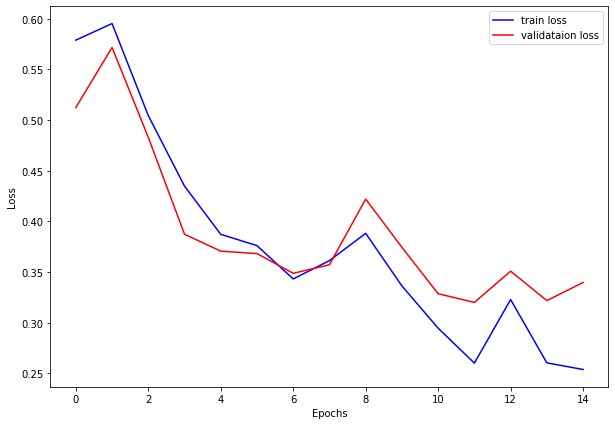

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='blue', linestyle='-', label='train loss')
plt.plot(val_losses, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# check = torch.rand(5,1,256,256)
# model = BoneAgePredictor();
# print(model.forward(check).size())

In [26]:
# check = pd.read_csv(dataset_path('boneage-training-dataset.csv'));
# print(check)
# print(check['boneage'][0])
# print(check['id'][1])
# check = Image.open(dataset_path('boneage-training-dataset',str(check['id'][1])+'.png')).resize((256,256))
# print(check)
# # check = transform(check)
# # print(check.size())
# # check = torch.from_numpy(np.array(check['boneage'][0]))
# # print(check)